In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\Sriram Saran Cheruvu\.conda\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import h5py

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import io


Using TensorFlow backend.
C:\Users\Sriram Saran Cheruvu\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sriram Saran Cheruvu\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sriram Saran Cheruvu\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

# Load the Data

In [6]:
# Assign the data path.
data_path = "hin.txt"

# Read in the data.
lines = io.open(data_path, encoding = "utf-8").read().split("\n")
lines  = lines[:-1]
print(lines[1])
# Split the data into input and target sequences.
lines = [line.split("\t") for line in lines]
print(lines[0])
# We define the starting signal to be "\t" and the
# ending signal to be "\n". These signals tell the
# model that when it sees "\t" it should start
# producing its translation and produce "\n" when
# it wants to end its translation. Let us add
# "\t" to the start and "\n" to the end 
# of all input and output sentences.
lines = [("\t" + line[0] + "\n", "\t" + line[1] + "\n") for
            line in lines]

Jump.	उछलो.
['Help!', 'बचाओ!']


In [9]:
print (lines[2][1])

	कूदो.



## Compute Sentence Lengths

In [10]:
# Compute the input and output lengths.
input_lengths = np.array([len(line[0]) for line in lines])
output_lengths = np.array([len(line[1]) for line in lines])

In [12]:
print (len(input_lengths))

2869


[75, 80, 0, 120]

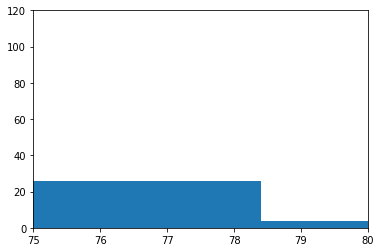

In [13]:
plt.hist(input_lengths)
plt.axis([75,80, 0 , 120])

[85, 89, 0, 20]

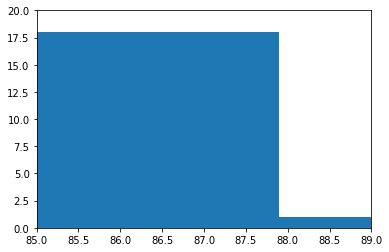

In [14]:
plt.hist(output_lengths)
plt.axis([85,89,0,20])

In [15]:
english = 78
hindi = 87

In [16]:
line1 = []
for i in range(len(input_lengths)):
    if(input_lengths[i]<75 and output_lengths[i]<85):
        line1 = line1 + [lines[i]]
        

In [18]:
 len(line1)

2856

## Input Length

Plotted the histogram of the length of the input sentences and choose the length that makes the most sense. 

The reason we don't want sentences that are too long is because the computation becomes trickier for longer sentences and the performance also degrades. However we also want as many sentences in our dataset as possible.

Thus it is important to choose the right length and discard sentences longer than this.

## Output Length

Repeat the same for the lengths of the output sentences

In [19]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2869  # Number of samples to train on.

In [20]:
input_texts = [(line[0]) for line in line1]
target_texts = [(line[1]) for line in line1]

In [21]:
input_characters = set()
target_characters = set()

In [22]:
for input_text in input_texts:
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

for target_text in target_texts:
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [24]:
print (len(input_characters))
print (len(target_characters))

72
92


In [25]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [26]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2856
Number of unique input tokens: 72
Number of unique output tokens: 92
Max sequence length for inputs: 74
Max sequence length for outputs: 82


In [27]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [28]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [29]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [30]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [31]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [32]:
epochs = 100

In [33]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2284 samples, validate on 572 samples
Epoch 1/100
2284/2284 [==============================] - 24s 10ms/step - loss: 1.2298 - val_loss: 1.8767
Epoch 2/100
2284/2284 [==============================] - 22s 10ms/step - loss: 1.1327 - val_loss: 1.8302
Epoch 3/100
2284/2284 [==============================] - 21s 9ms/step - loss: 1.0742 - val_loss: 1.7571
Epoch 4/100
2284/2284 [==============================] - 21s 9ms/step - loss: 0.9791 - val_loss: 1.6378
Epoch 5/100
2284/2284 [==============================] - 21s 9ms/step - loss: 0.9517 - val_loss: 1.5416
Epoch 6/100
2284/2284 [==============================] - 21s 9ms/step - loss: 0.8748 - val_loss: 1.4701
Epoch 7/100
2284/2284 [==============================] - 21s 9ms/step - loss: 0.8174 - val_loss: 1.3947
Epoch 8/100
2284/2284 [==============================] - 21s 9ms/step - loss: 0.7837 - val_loss: 1.3372
Epoch 9/100
2284/2284 [=

2284/2284 [==============================] - 23s 10ms/step - loss: 0.2841 - val_loss: 1.3366
Epoch 73/100
2284/2284 [==============================] - 24s 11ms/step - loss: 0.2803 - val_loss: 1.3512
Epoch 74/100
2284/2284 [==============================] - 23s 10ms/step - loss: 0.2753 - val_loss: 1.3428
Epoch 75/100
2284/2284 [==============================] - 22s 10ms/step - loss: 0.2691 - val_loss: 1.3816
Epoch 76/100
2284/2284 [==============================] - 22s 10ms/step - loss: 0.2675 - val_loss: 1.3624
Epoch 77/100
2284/2284 [==============================] - 22s 10ms/step - loss: 0.2603 - val_loss: 1.3912
Epoch 78/100
2284/2284 [==============================] - 22s 10ms/step - loss: 0.2559 - val_loss: 1.4189
Epoch 79/100
2284/2284 [==============================] - 23s 10ms/step - loss: 0.2526 - val_loss: 1.4137
Epoch 80/100
2284/2284 [==============================] - 25s 11ms/step - loss: 0.2475 - val_loss: 1.4207
Epoch 81/100
2284/2284 [==============================] - 2

In [34]:
model.save('s2s.h5')


In [35]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [36]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


In [37]:
for seq_index in range(100):
    
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_texts[seq_index])
    print(decoded_sentence)

-
	Help!

वह अपने कुत्ते को खादरा भर सकता।

-
	Jump.

हम सब तुम्हारी सेहत के लिए बहुत छोटा है।

-
	Jump.

हम सब तुम्हारी सेहत के लिए बहुत छोटा है।

-
	Jump.

हम सब तुम्हारी सेहत के लिए बहुत छोटा है।

-
	Hello!

वह अफ़वाह सच्चिय सकता है।

-
	Hello!

वह अफ़वाह सच्चिय सकता है।

-
	Cheers!

हमारे पास कितनी कट्रियाँगें मुलाई है।

-
	Cheers!

हमारे पास कितनी कट्रियाँगें मुलाई है।

-
	Got it?

मुझे अपने आपसी बास नहीं जातते हैं।

-
	I'm OK.

मैं अपनी काई बजास सुन किता हूँ।

-
	Awesome!

हम सब तुम्हारी सेहत के लिए बहुत छोटा है।

-
	Come in.

मुझे अपने आपसी बास नहीं जातते हैं।

-
	Get out!

मुझे अपने आपसी बादी नाड़ के निक्यों के पाला नहीं है।

-
	Go away!

हम सब तुम्हारी सेहत के लिए बहुत छोटा है।

-
	Goodbye!

मुझे अपने आपसी बास नहीं जातते हैं।

-
	Perfect!

मुझे अपने आपसी बादी नाड़ के निक्यों के पाला नहीं है।

-
	Perfect!

मुझे अपने आपसी बादी नाड़ के निक्यों के पाला नहीं है।

-
	Welcome.

हमारे साथ आओ।

-
	Welcome.

हमारे साथ आओ।

-
	Have fun.

हम सब तुम्हारी सेहत के लिए बहुत छोटा है।

-
	Have 